In [1]:
import os
import platform
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

# Check which platform is running the notebook
if platform.system() == 'Windows':
    PROJECT_PATH = "\\".join(os.getcwd().split('\\')[:-1])
else:
    # Assuming a Unix based platform
    PROJECT_PATH = "/".join(os.getcwd().split('/')[:-1])

DATA_PATH = os.path.join(PROJECT_PATH, 'data')
TRAIN_DATA_PATH = os.path.join(DATA_PATH, 'train.csv')

# Load the training dataset
house_prices_train = pd.read_csv(TRAIN_DATA_PATH)
house_prices_train = house_prices_train.drop('Id', axis=1)
house_prices_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Creating a training and testing set from the data

In [2]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
test_size = 0.3
target_feature = 'SalePrice'

X = house_prices_train.drop(target_feature, axis=1)
y = house_prices_train[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=test_size)

In [3]:
print('Training size: ', X_train.shape)
print('Testing size: ', X_test.shape)

Training size:  (1022, 79)
Testing size:  (438, 79)


## Processing the data

### Removing features with missing values

In [4]:
def remove_missing_features(X, threshold=0.8, verbose=False):
    features = X.columns
    features_to_remove = []
    dataset_size = X.shape[0]
    for f in features:
        missing_count = X[X[f].isna()].shape[0]
        missing_ratio = missing_count / dataset_size
        if missing_ratio > threshold:
            features_to_remove.append(f) 
            if verbose:
                print("{:14}{:.3f}%".format(f, missing_ratio * 100))
    return X.drop(features_to_remove, axis=1)

# Extract a dataset with null features removed
X_train_df = remove_missing_features(X_train, verbose=True)

Alley         93.542%
PoolQC        99.511%
Fence         80.235%
MiscFeature   96.086%


### Removing features with a single value

Removing features that all have the same value

In [5]:
def remove_single_values(X, verbose=False):
    features = X.columns
    features_to_remove = []
    for f in features:
        value_count = X[f].nunique()
        if value_count == 1:
            features_to_remove.append(f)
            if verbose:
                print('Removing ', f)
    return X.drop(features_to_remove, axis=1)

X_train_df = remove_single_values(X_train_df)

### Removing Correlated Features

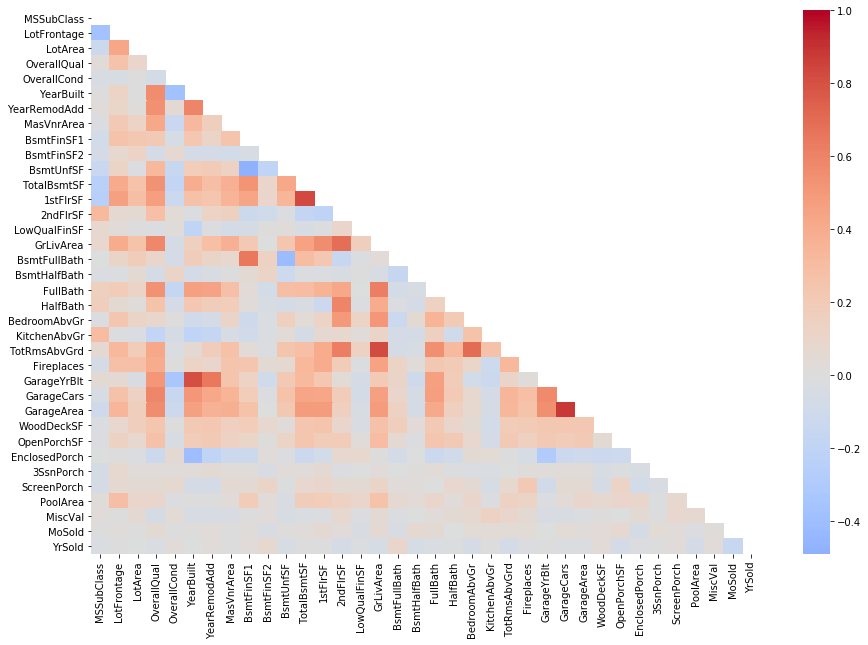

In [6]:
def plot_correlation_triangle(X):
    corr = X.corr()

    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    plt.figure(figsize=(15, 10))
    sns.heatmap(corr, mask=mask, center=0, cmap= 'coolwarm')
    plt.show()

# Plot the heatmap first to see what the correlations are like
plot_correlation_triangle(X_train_df)

In [7]:
def remove_highly_correlate_features(X, threshold=0.9):
    corr = X.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_remove = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(to_remove, axis=1)

X_train_df = remove_highly_correlate_features(X_train_df)

## Impute missing values

In [8]:
def features_with_missing_values(X):
    features = X.columns
    dataset_size = X.shape[0]
    to_impute = []
    for f in features:
        feature_count = X[X[f].isna()].shape[0]
        if (feature_count != dataset_size) and (feature_count != 0):
            to_impute.append(f)
    return to_impute

numeric_features_to_impute = features_with_missing_values(X_train_df)
numeric_features_to_impute

['LotFrontage',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond']

Creating a basic impute pipeline where categorical values will have the most frequent value and numeric values will have the median.

This pipeline will also process the data by applying a log transformation

### Processing Pipeline

In [9]:
from sklearn.base import TransformerMixin

class SparseToDense(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.todense()

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer

numeric_cols = X_train_df.select_dtypes(['float64', 'int64']).columns.tolist()
cateorical_cols = X_train_df.select_dtypes(['object']).columns.tolist()

numeric_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('log', FunctionTransformer(np.log1p))
])

categorical_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'))
])

processing_pipeline = Pipeline([
    ('process', ColumnTransformer([
        ('numeric', numeric_pipeline, numeric_cols),
        ('categorical', categorical_pipeline, cateorical_cols),
    ])),
    ('dense', SparseToDense())
])

In [11]:
X_train_processed = processing_pipeline.fit_transform(X_train)
X_train_processed.shape

(1022, 270)

In [12]:
from sklearn.feature_selection import SelectKBest, f_regression

# Get the best 50 features
k_best = SelectKBest(score_func=f_regression, k=50)
X_train_k_best = k_best.fit_transform(X_train_processed, y_train)
X_train_k_best.shape

(1022, 50)

In [13]:
processed_cateogires_features = np.concatenate(
    processing_pipeline['process'].transformers_[1][1]['one_hot'].categories_
)

processed_columns = np.asarray(numeric_cols + processed_cateogires_features.tolist())

In [14]:
feature_indices = np.where(k_best.get_support())[0].tolist()
processed_columns[feature_indices]

array(['LotFrontage', 'LotArea', 'OverallQual', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'RL', 'RM', 'Reg', 'NoRidge', 'NridgHt', 'VinylSd',
       'VinylSd', 'None', 'Stone', 'Ex', 'Gd', 'TA', 'CBlock', 'PConc',
       'Ex', 'TA', 'Gd', 'No', 'GLQ', 'Ex', 'TA', 'N', 'Y', 'Ex', 'Gd',
       'TA', 'Ex', 'Detchd', 'Fin', 'Unf', 'New', 'Partial'], dtype='<U13')

## Modelling the data

In [15]:
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.linear_model import SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor

clfs = [
    SVR(),
    RandomForestRegressor(random_state=RANDOM_STATE),
    GradientBoostingRegressor(random_state=RANDOM_STATE),
    GaussianProcessRegressor(random_state=RANDOM_STATE),
    SGDRegressor(random_state=RANDOM_STATE),
    Ridge(random_state=RANDOM_STATE),
    KNeighborsRegressor()
]

for clf in clfs:
    clf_name = clf.__class__.__name__
    print('Training ', clf_name)
    clf.fit(X_train_k_best, y_train)

Training  SVR
Training  RandomForestRegressor
Training  GradientBoostingRegressor
Training  GaussianProcessRegressor
Training  SGDRegressor
Training  Ridge
Training  KNeighborsRegressor


In [16]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def root_mean_log_error(y_true, y_pred):
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except ValueError:
        return -1000

In [17]:
for idx, clf in enumerate(clfs):
    y_pred = clf.predict(X_train_k_best)
    rmse = root_mean_squared_error(y_pred, y_train)
    rmlse = root_mean_log_error(y_pred, y_train)
    print('{} - {:35} RMSE: {:.3f}, RMLSE: {:.3f}'.format(idx, clf.__class__.__name__, rmse, rmlse))

0 - SVR                                 RMSE: 79258.366, RMLSE: 0.394
1 - RandomForestRegressor               RMSE: 12589.591, RMLSE: 0.064
2 - GradientBoostingRegressor           RMSE: 15698.073, RMLSE: 0.099
3 - GaussianProcessRegressor            RMSE: 0.000, RMLSE: 0.000
4 - SGDRegressor                        RMSE: 7642033.598, RMLSE: -1000.000
5 - Ridge                               RMSE: 31973.888, RMLSE: -1000.000
6 - KNeighborsRegressor                 RMSE: 33509.813, RMLSE: 0.162


The most promising models are:

1. Random Forest Regressor
2. Gradient Boosting Regressor
3. Potentially Gaussian Process Regressor, however this looks like it is overfitting its data        

In [18]:
from sklearn.model_selection import cross_val_score

def cross_val_regression(clf, X, y, cv=3):
    neg_mse_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_error', cv=cv)
    neg_log_scores = cross_val_score(clf, X, y, scoring='neg_mean_squared_log_error', cv=cv)
    return {
        'rmse': (np.sqrt(-neg_mse_scores)).mean(),
        'rmlse': (np.sqrt(-neg_log_scores)).mean()
    }

In [19]:
guass_reg = GaussianProcessRegressor(random_state=RANDOM_STATE)
scores = cross_val_regression(guass_reg, X_train_k_best, y_train, cv=5)
print('GaussianProcessRegressor: RMSE {:.3f}, RMLSE: {:.3f}'.format(scores['rmse'], scores['rmlse']))

GaussianProcessRegressor: RMSE 126305.140, RMLSE: 1.607


Apply K cross folds, we can observe that the results of the model are not that great in reality.

Cross folders on Random Forest Regressor and Gradient Boosting Regressor

In [20]:
rand_reg = RandomForestRegressor(random_state=RANDOM_STATE)
grad_boost_reg = GradientBoostingRegressor(random_state=RANDOM_STATE)

for clf in [rand_reg, grad_boost_reg]:
    scores = cross_val_regression(clf, X_train_k_best, y_train, cv=5)
    print('{}: RMSE {:.3f}, RMLSE: {:.3f}'.format(clf.__class__.__name__, scores['rmse'], scores['rmlse']))

RandomForestRegressor: RMSE 34377.051, RMLSE: 0.158
GradientBoostingRegressor: RMSE 36706.326, RMLSE: 0.157


Looking at the results, the RandomForestRegressor is performing much better compared to the GradientBoostingRegressor

## Refining the best model

Refining the random forest regressor

In [21]:
from sklearn.model_selection import GridSearchCV

# Create the baseline model
rand_reg = RandomForestRegressor(random_state=RANDOM_STATE)

param_grid = [
    {
        'n_estimators': [100, 200, 300, 400, 500],
        'criterion': ['mse', 'mae'],
        'warm_start': [True, False],
        'bootstrap': [True, False],
        'n_jobs': [2]
    }
]

rand_reg_grid_search = GridSearchCV(rand_reg, param_grid, cv=3, verbose=2, n_jobs=2, scoring='neg_mean_squared_error')
rand_reg_grid_search.fit(X_train_k_best, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:   32.2s
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed:  5.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

Looking at the results

In [22]:
rand_reg_grid_search.best_params_

{'bootstrap': True,
 'criterion': 'mae',
 'n_estimators': 400,
 'n_jobs': 2,
 'warm_start': True}

In [23]:
np.sqrt(-rand_reg_grid_search.best_score_)

32613.000375823467

In [24]:
best_rand_reg = rand_reg_grid_search.best_estimator_

scores = cross_val_regression(best_rand_reg, X_train_k_best, y_train, cv=5)
print('Best Random Forest Regressor Model: RMSE: {:.3f} RMLSE: {:.3f}'.format(scores['rmse'], scores['rmlse']))

Best Random Forest Regressor Model: RMSE: 34031.142 RMLSE: 0.159


Compared to the baseline model, there is only a minor improvement in the results

## Applying dimensionality reduction

Appling dimensionality reduction to the best 50 features dataset to see if we can get the same result with fewer features

In [25]:
from sklearn.decomposition import PCA

# Remove by getting data that has 99% variance
pca = PCA(random_state=RANDOM_STATE, n_components=0.99)
X_train_pca = pca.fit_transform(X_train_k_best)

In [26]:
n_components = pca.n_components_
input_features = X_train_k_best.shape[1]
print('PCA {}, Before: {}, {} features removed'.format(
    n_components,
    input_features,
    (input_features - n_components)))

PCA 30, Before: 50, 20 features removed


In [27]:
# Applying this dataset to see if the model maintains the same results
rand_reg = RandomForestRegressor(random_state=RANDOM_STATE, **rand_reg_grid_search.best_params_)

%time
scores = cross_val_regression(rand_reg, X_train_pca, y_train, cv=5)

Wall time: 0 ns


In [28]:
print('PCA Random Forest: RMSE {:.3f}, RMLSE {:.3f}'.format(scores['rmse'], scores['rmlse']))

PCA Random Forest: RMSE 39295.148, RMLSE 0.190


A minor decrease in performance compared to the original features. Though still relatively close to the original best model

Apply PCA again to the K best dataset, but this time try to get the dataset reduce into 2D so it can be visualised

In [29]:
pca_2d = PCA(random_state=RANDOM_STATE, n_components=2)
X_train_2d = pca_2d.fit_transform(X_train_k_best)

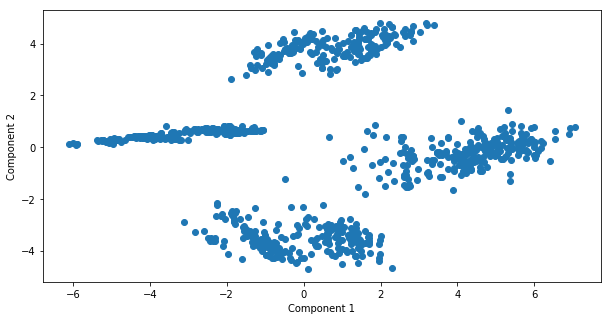

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1])
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

We can clearly see 4 distinct clusters in the dataset. Applying some unsupervised methods such as Kmeans to see if there is any significance to these groups.

### Clustering the results

In [31]:
from sklearn.cluster import KMeans

def kmeans_elbow_approach(max_clusters, X):
    sum_squared_distances = []
    for c in range(2, max_clusters + 1):
        kmeans = KMeans(random_state=RANDOM_STATE, n_clusters=c)
        kmeans.fit(X)
        sum_squared_distances.append(kmeans.inertia_)
    return sum_squared_distances

def plot_elbow_approach(max_clusters, sum_squared_distances):
    r = range(2, max_clusters + 1)
    plt.plot(r, sum_squared_distances, '-o')
    plt.xlabel('N Clusters')
    plt.ylabel('Sum of Squared Errors')
    plt.show()

In [32]:
sum_squared_distances_kmeans = kmeans_elbow_approach(10, X_train_2d)

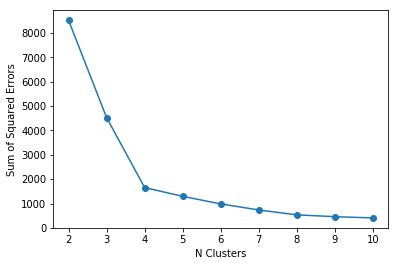

In [33]:
plot_elbow_approach(10, sum_squared_distances_kmeans)

In [34]:
k_means = KMeans(random_state=RANDOM_STATE, n_clusters=4)
clusters = k_means.fit_predict(X_train_2d)

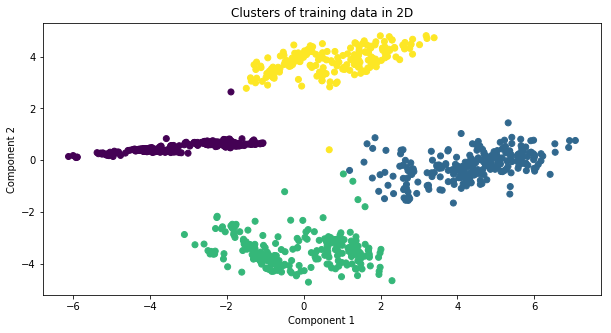

In [35]:
plt.figure(figsize=(10, 5))
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=clusters)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('Clusters of training data in 2D')
plt.show()

We can see 4 distinct clusters from the results.

In [36]:
# Create a dataframe of the 4 clusters
k_best_columns = processed_columns[feature_indices].tolist()
X_train_k_df = pd.DataFrame(X_train_k_best, columns=k_best_columns)
X_train_k_df['cluster'] = clusters

In [37]:
X_train_k_df['cluster'].value_counts().sort_index()

0    351
1    240
2    243
3    188
Name: cluster, dtype: int64

In [63]:
X_train_clusters_df = X_train.copy()
X_train_clusters_df['cluster'] = clusters
X_train_clusters_df['SalePrice'] = y_train

In [75]:
def get_cluster_data(X, cluster_idx, cols):
    return X[X['cluster'] == cluster_idx][cols]

k_original_features = numeric_cols + cateorical_cols + [target_feature, 'cluster']

cluster_dfs = []
for c in range(0, 4):
    cluster_df = get_cluster_data(X_train_clusters_df, c, k_original_features)
    cluster_dfs.append(cluster_df)
print(len(cluster_dfs))

4


### Plot the sales price for each cluster

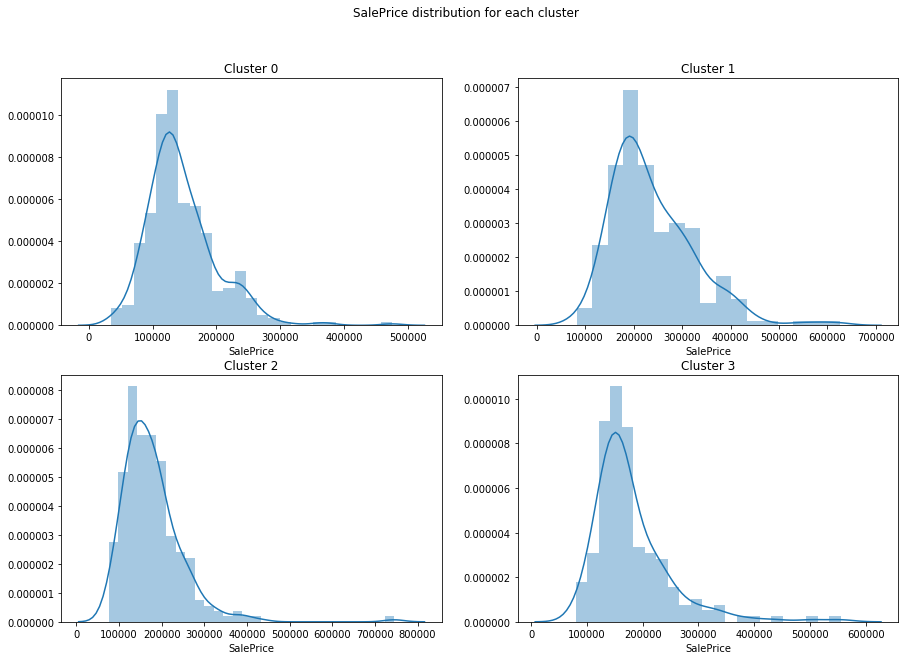

In [91]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('SalePrice distribution for each cluster')

# Set each plot title
axs[0, 0].set_title('Cluster 0')
axs[0, 1].set_title('Cluster 1')
axs[1, 0].set_title('Cluster 2')
axs[1, 1].set_title('Cluster 3')

# Plot the results
sns.distplot(cluster_dfs[0].SalePrice, ax=axs[0, 0])
sns.distplot(cluster_dfs[1].SalePrice, ax=axs[0, 1])
sns.distplot(cluster_dfs[2].SalePrice, ax=axs[1, 0])
sns.distplot(cluster_dfs[3].SalePrice, ax=axs[1, 1])
fig.show()

The distribution of SalesPrice for each cluster looks relatively the same within each cluster. Cluster 0 and cluster 3 more cheaper properties than cluster 2 and 3.

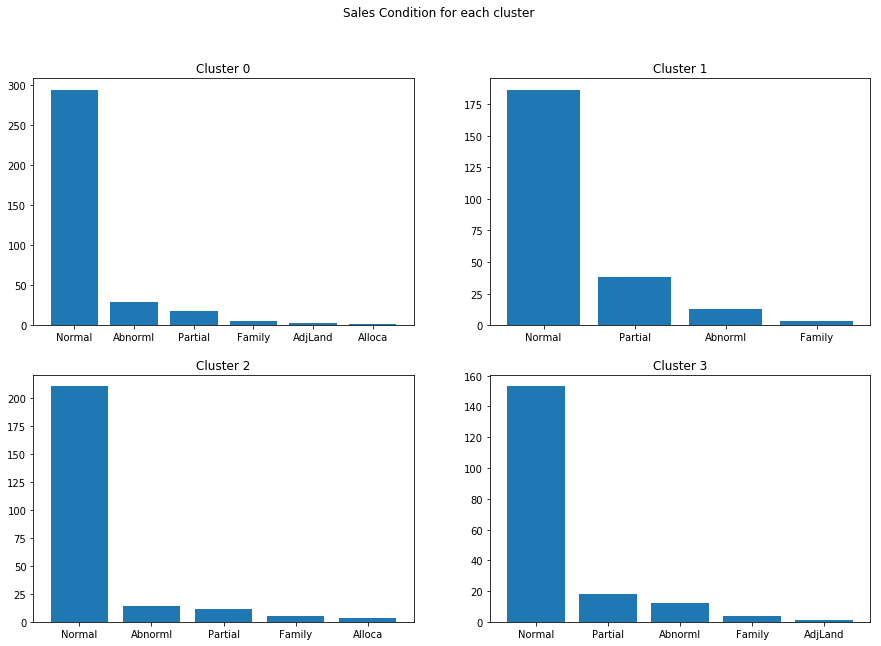

In [103]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Sales Condition for each cluster')

# Set each plot title
axs[0, 0].set_title('Cluster 0')
axs[0, 1].set_title('Cluster 1')
axs[1, 0].set_title('Cluster 2')
axs[1, 1].set_title('Cluster 3')

# Cluster 0
sales_condition = cluster_dfs[0].SaleCondition.value_counts()
axs[0, 0].bar(sales_condition.index, sales_condition.values)

# Cluster 1
sales_condition = cluster_dfs[1].SaleCondition.value_counts()
axs[0, 1].bar(sales_condition.index, sales_condition.values)

# Cluster 2
sales_condition = cluster_dfs[2].SaleCondition.value_counts()
axs[1, 0].bar(sales_condition.index, sales_condition.values)


# Cluster 3
sales_condition = cluster_dfs[3].SaleCondition.value_counts()
axs[1, 1].bar(sales_condition.index, sales_condition.values)
fig.show()

Each clusters shows the same pattern with Normal being pretty dominant. Cluster 1 and 2 thouugh have more Abnormal than Partial homes.

To determine which features should be used for cluster analysis, we can the use the random forest trained earlier to see which features were importance to the result

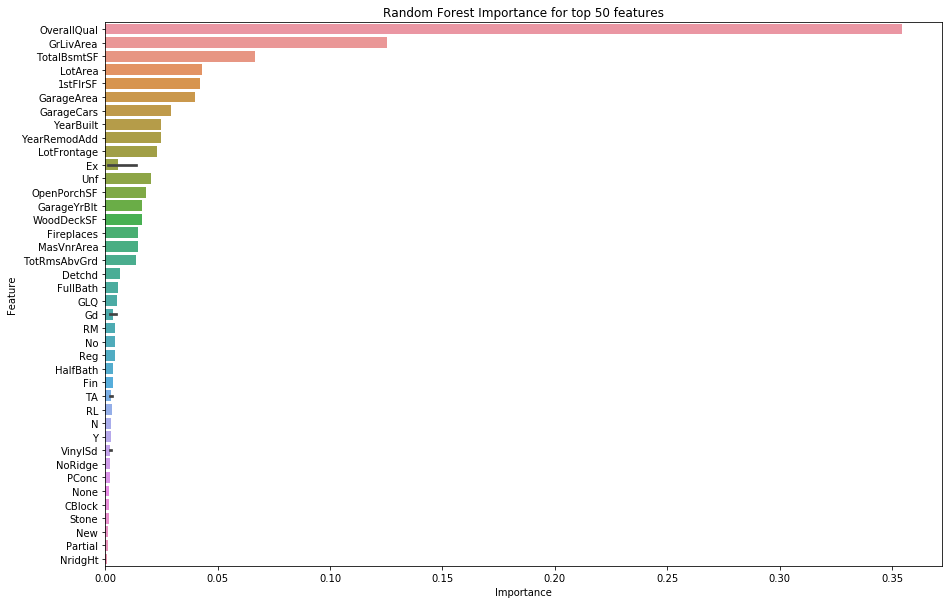

In [132]:
# Get the features
k_best_forest_importance = best_rand_reg.feature_importances_
k_best_forest_features = processed_columns[feature_indices]

# Sort based on scores
sorted_indices = np.argsort(k_best_forest_importance)[::-1]

# Apply the sorted results
k_best_forest_importance = k_best_forest_importance[sorted_indices]
k_best_forest_features = k_best_forest_features[sorted_indices]

# Plot
plt.figure(figsize=(15, 10))
sns.barplot(k_best_forest_importance, k_best_forest_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Importance for top 50 features')
plt.show()

In [136]:
# Take all features that have an importance greater than 0.01
threshold = k_best_forest_importance > 0.01
forest_best_features = k_best_forest_features[threshold]

In [142]:
# Get the total number of features
forest_best_features.shape

(18,)

In [143]:
X_feature_importance_df = X_train_k_df[forest_best_features.tolist() + ['cluster']]

Use `OverallQuality` first as this was the most importance feature

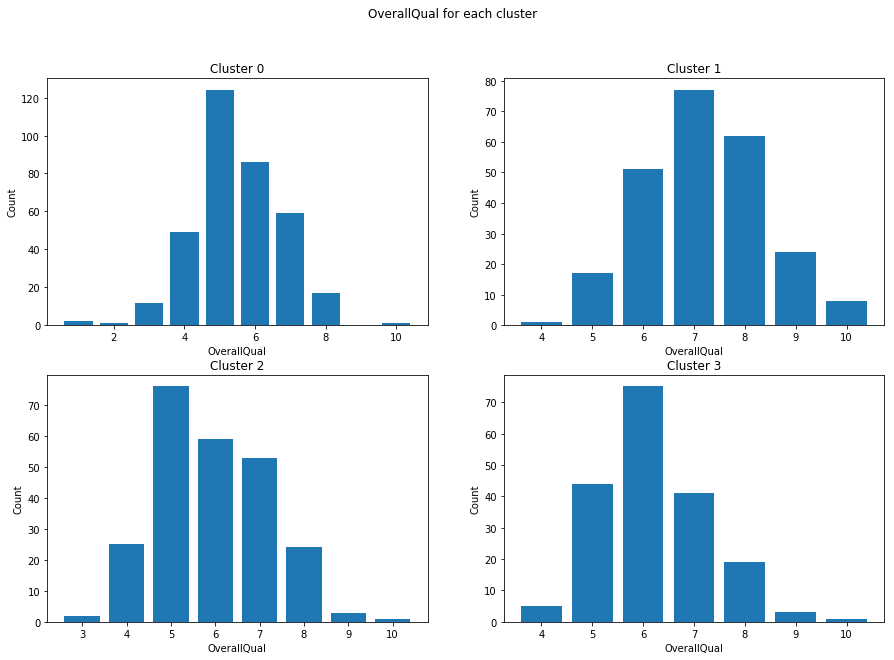

In [160]:
def plot_distribution_for_clusters(feature):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('{} distribution for each cluster'.format(feature))

    # Set each plot title
    axs[0, 0].set_title('Cluster 0')
    axs[0, 1].set_title('Cluster 1')
    axs[1, 0].set_title('Cluster 2')
    axs[1, 1].set_title('Cluster 3')

    # Plot the results
    sns.distplot(cluster_dfs[0][feature], ax=axs[0, 0])
    sns.distplot(cluster_dfs[1][feature], ax=axs[0, 1])
    sns.distplot(cluster_dfs[2][feature], ax=axs[1, 0])
    sns.distplot(cluster_dfs[3][feature], ax=axs[1, 1])
    fig.show()
    
def plot_categorical_for_clusters(feature):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('{} for each cluster'.format(feature))

    # Set each plot title
    axs[0, 0].set_title('Cluster 0')
    axs[0, 1].set_title('Cluster 1')
    axs[1, 0].set_title('Cluster 2')
    axs[1, 1].set_title('Cluster 3')
    
    axs[0, 0].set_xlabel(feature)
    axs[0, 1].set_xlabel(feature)
    axs[1, 0].set_xlabel(feature)
    axs[1, 1].set_xlabel(feature)
    
    axs[0, 0].set_ylabel('Count')
    axs[0, 1].set_ylabel('Count')
    axs[1, 0].set_ylabel('Count')
    axs[1, 1].set_ylabel('Count')

    # Cluster 0
    sales_condition = cluster_dfs[0][feature].value_counts()
    axs[0, 0].bar(sales_condition.index, sales_condition.values)

    # Cluster 1
    sales_condition = cluster_dfs[1][feature].value_counts()
    axs[0, 1].bar(sales_condition.index, sales_condition.values)

    # Cluster 2
    sales_condition = cluster_dfs[2][feature].value_counts()
    axs[1, 0].bar(sales_condition.index, sales_condition.values)


    # Cluster 3
    sales_condition = cluster_dfs[3][feature].value_counts().sort_index()
    axs[1, 1].bar(sales_condition.index, sales_condition.values)
    fig.show()
    
plot_categorical_for_clusters('OverallQual')

Distribution of the overall qualuity between clusters looks pretty similar. Cluster 1 has more in the higher ranges between 7-10, comapred to the other 3 clusters.

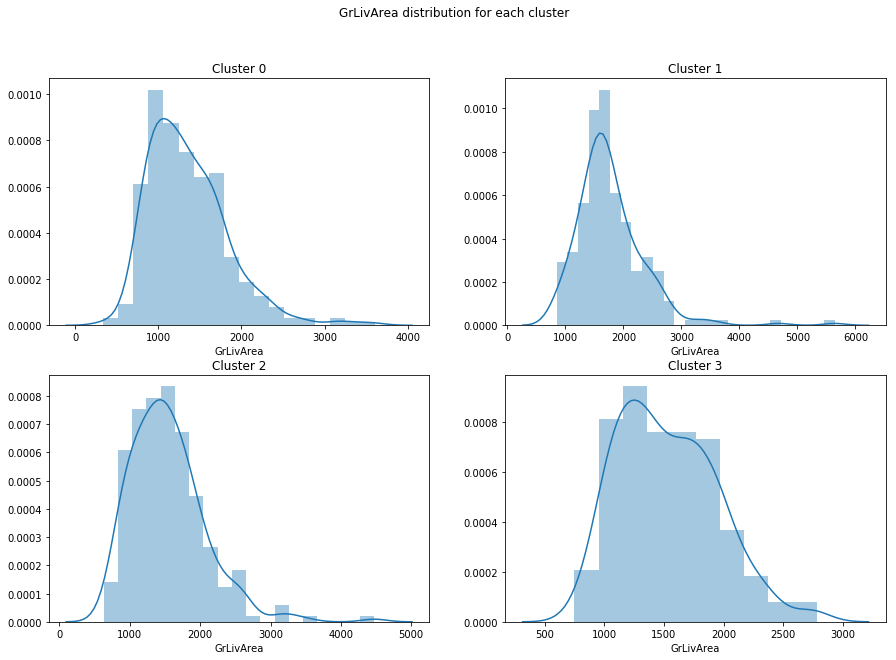

In [162]:
plot_distribution_for_clusters('GrLivArea')

Again, for the clustesr the distribution looks roughly the same. Clusters 0, 1, and 2 have a few outliers for `GrLivArea` compared to cluster 3

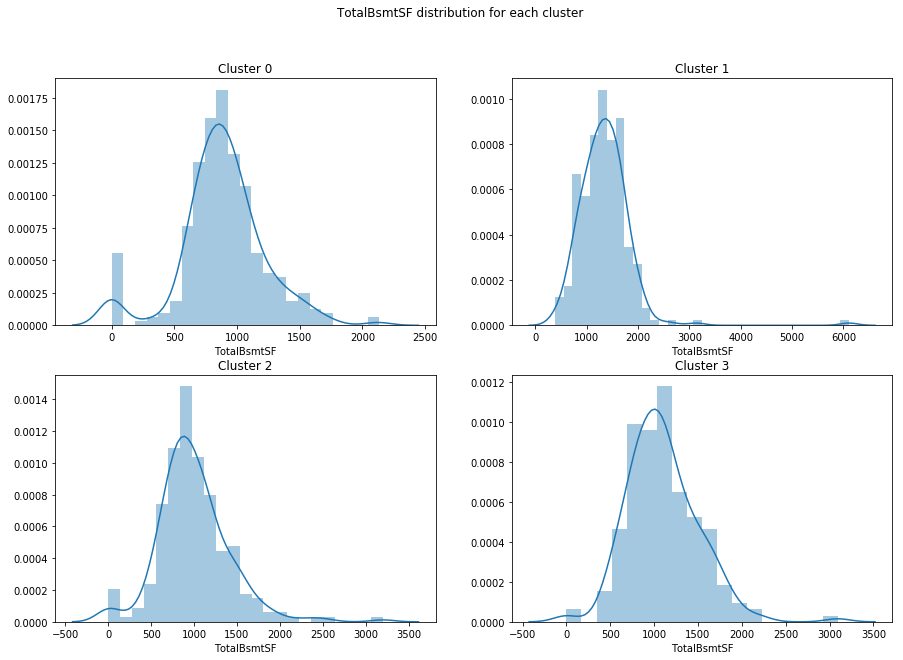

In [167]:
plot_distribution_for_clusters('TotalBsmtSF')

`TotalBsmtSF` = Total square feet of basement area

For `TotalBsmtSF`, the distribution looks more or less the same where the majoirty of data is between 500 - 2000. A significant outlier exists in cluster 1 where 6000 `TotalBsmtSF` was found

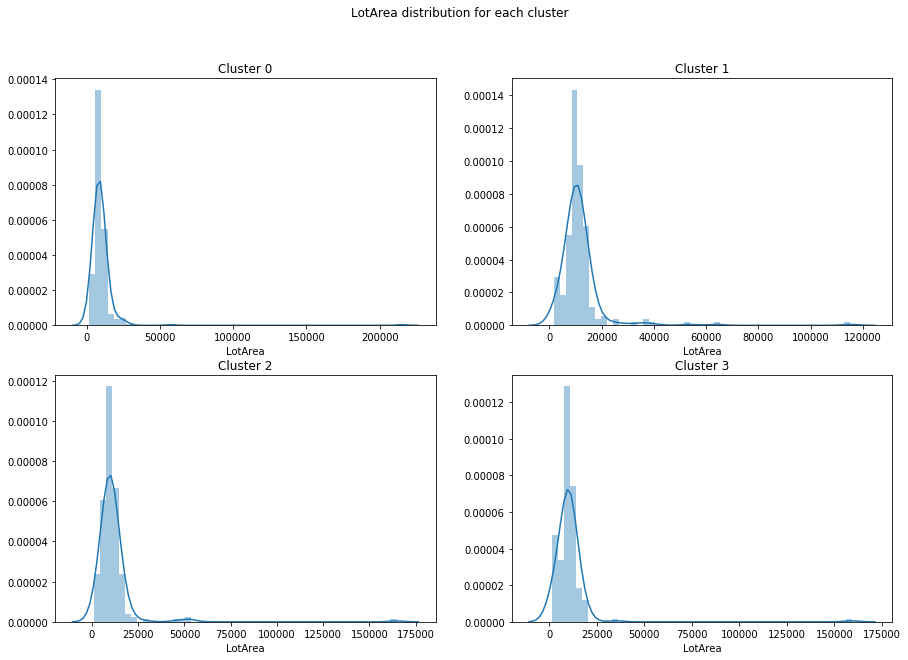

In [168]:
plot_distribution_for_clusters('LotArea')

Again, the distribution for `LotArea` looks pretty much the same across all 4 clusters

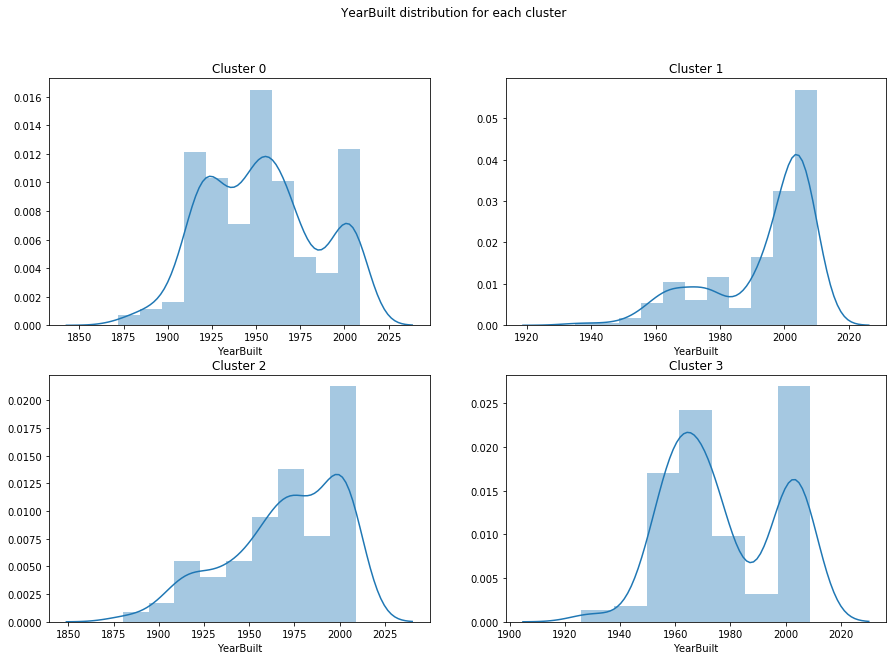

In [169]:
plot_distribution_for_clusters('YearBuilt')

For `YearBuilt` we can see some significant changes between the clusters:

* Cluster 0 has more results between 1915 - 1950 with a few in the 60s
* Cluster 1 is focused more on houses from the 1990 to 2000s onwards
* Cluster 2 has a few more houses in the 1970s and 2000s
* Cluster 3 is foucsed more in the 1960s and 1970s with a few in the 2000s

## Conclusions

* Improvements in the features are required in order to reduce the overall error rate of the model
* 4 distinct clusters were found but given the amount of features, it will take some time to go through each one to validate which ones are the cause of the clutering. I belive `YearBuild` is a factor of this but I will need to go through every feature to validate this.
* Need to do some feature engineering to reduce the overall complexity of the model
* Need to remove outliers from the dataset

## Removing Outliers

### Plot the target feature

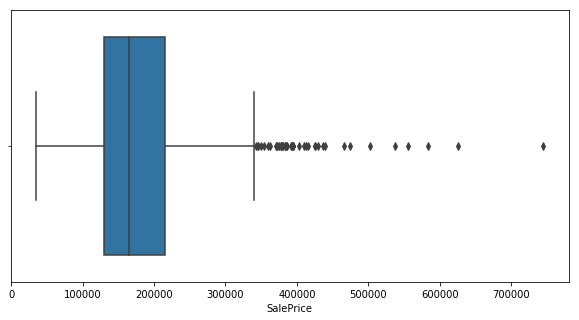

In [182]:
plt.figure(figsize=(10, 5))
sns.boxplot(y_train)
plt.show()

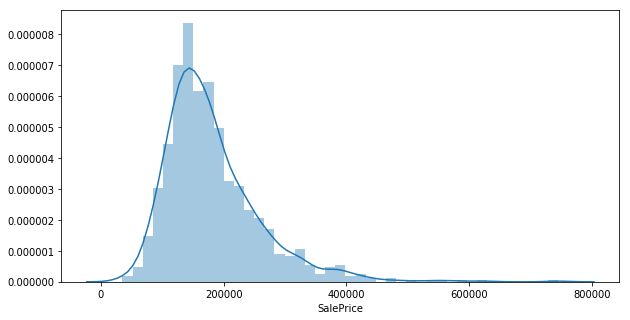

In [209]:
plt.figure(figsize=(10, 5))
sns.distplot(y_train)
plt.show()

All the outliers for the target feature after the maximum value. So will remove anything above the maximum

### Removing the outliers

In [207]:
quantiles = y_train.quantile([0.25, 0.75]).values

# Q1 at index 0 and Q3 at index 1
iqr = quantiles[1] - quantiles[0]
outlier_threshold = quantiles[1] + (1.5 * iqr)
outlier_threshold

342500.0

In [234]:
feature_inliers_indices = np.where(y_train < outlier_threshold)[0]

# Extract the inliers from the dataset
X_train_inliers = X_train.iloc[feature_inliers_indices]
y_train_inliers = y_train.iloc[feature_inliers_indices]

# Validate they are the same size 
assert X_train_inliers.shape[0] == y_train_inliers.shape[0]

## Retrain the processing pipeline

In [235]:
X_train_inliers_processed = processing_pipeline.fit_transform(X_train_inliers)

In [236]:
# Apply the best parameters from previous runs
rand_reg_v2 = RandomForestRegressor(random_state=RANDOM_STATE, **rand_reg_grid_search.best_params_)
rand_reg_v2.fit(X_train_inliers_processed, y_train_inliers)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=2, oob_score=False,
                      random_state=42, verbose=0, warm_start=True)

In [238]:
y_pred = rand_reg_v2.predict(X_train_inliers_processed)
rmse = root_mean_squared_error(y_train_inliers, y_pred)
rmsle = root_mean_log_error(y_train_inliers, y_pred)

print('Removed Outlier Random Forest: RMSE {:.3f} RMSLE: {:.3f}'.format(rmse, rmsle))

Removed Outlier Random Forest: RMSE 8357.367 RMSLE: 0.057


In [239]:
X_train_inliers_processed.shape

(981, 270)

From removing the outliers from the training data, there has been a dramatic reduction in the error rate. Considering this is using over 270 features compared to the previous model that was using a refined 50 features, this is a significant improvement. 

Next I will do a cross validation run to get the average performance.

Then, I will understand which features were significant in making the prediction and also reduce the 270 features into 50 features to see if the error rate improves even further.

In [240]:
# Perform a K cross fold
scores = cross_val_score(rand_reg_v2, X_train_inliers_processed, y_train_inliers, cv=3, scoring='neg_mean_squared_error')

In [243]:
np.sqrt(-scores).mean()

22877.905083677575

Upon applying a cross validation, the average RMSE is about 10,000 less than the original model with the outliers included in the training dataset